I think a SWIN transformer might be good, it seems like it has versatile use cases. I think what I am doing is semantic segmentation, but instead of pixel values of 0 and 1, I think it is a distribution between 0 and 1 for a heatmap of KPs.

https://github.com/microsoft/Swin-Transformer

In [27]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import timm
import os

This dataset class loads grayscale images and heatmap labels, transforming the grayscale images to 3 channels (to match the Swin Transformer’s expectations). - not sure if this is a great way to do it, should figure out how to just keep the original RGB structure before Raghav dataset creation.

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms

# class FaceMapDataset(Dataset):
#     #def __init__(self, data_file="data/facemap_softlabels_test_RGB.pt", transform=None):
#     def __init__(self, data_file="data/facemap_softlabels.pt", transform=None):
#         super().__init__()
#         self.transform = transform
#         self.data, _, self.targets = torch.load(data_file)

#     def __len__(self):
#         return len(self.targets)

#     def __getitem__(self, index):
#         image, label = self.data[index].clone(), self.targets[index].clone()
        
#         # Print the shape of the image before repeating channels
#         print("Original image shape:", image.shape)  # Should show (1, 224, 224) or similar
        
#         # Convert grayscale to 3-channel by repeating the single channel
#         image = image.repeat(3, 1, 1)  # Converts (1, 224, 224) to (3, 224, 224)
        
#         # Apply transformations if provided (e.g., flipping for augmentation)
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label


# # Initialize the dataset with transformations for resizing and normalization if needed
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize if required (optional)
# ])

# dataset = FaceMapDataset(data_file="data/facemap_softlabels.pt", transform=transform)

# # Define DataLoader
# train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [28]:
#this should work with the actual RGB dataset images
# 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

class FaceMapDataset(Dataset):
    def __init__(self, data_file="data/facemap_softlabels_test_RGB.pt", transform=None):
        super().__init__()
        self.transform = transform
        self.data, _, self.targets = torch.load(data_file)
        #add this for data aug
        blur_radius=(1, 2)
        self.blur_radius = blur_radius
        rotation_degrees=15
        self.rotation_degrees = rotation_degrees

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        image, label = self.data[index].clone(), self.targets[index].clone()
        aug_type = (
            index % 5
        )  # 0: original, 1: flipped, 2: rotated, 3: zoomed, 4: blurred
        
        # Print the shape of the image to confirm it has 3 channels
        print("Loaded image shape:", image.shape)  # Should now show (3, 224, 224)
        
        # Apply transformations if provided (e.g., flipping for augmentation)
        if self.transform:
            image = self.transform(image)
#            # try adding image augmentation
#            if aug_type == 1:  # Flipping
#                image = image.flip([2])
#                label = label.flip([2])
#            elif aug_type == 2:  # Rotation
#                angle = (torch.rand(1).item() * 2 - 1) * self.rotation_degrees
#                image = TF.rotate(image, angle)
#                label = TF.rotate(label, angle)
#            elif aug_type == 3:  # Zooming
#                scale_factor = 1.1 if torch.rand(1).item() < 0.5 else 0.9
#                image = self.zoom(image, scale_factor)
#                label = self.zoom(label, scale_factor)
#            elif aug_type == 4:  # Gaussian Blur
#                # Random radius within the specified range
#                radius = (
#                    torch.rand(1).item() * (self.blur_radius[1] - self.blur_radius[0])
#                    + self.blur_radius[0]
#                )
#                image = TF.gaussian_blur(image, kernel_size=int(radius))
#                label = TF.gaussian_blur(label, kernel_size=int(radius))

        
        return image, label
    # added for image aug
    
    def zoom(self, img, scale_factor):
        # Calculate new dimensions
        _, h, w = img.shape
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)

        # Resize and center-crop back to the original size
        img = TF.resize(img, [new_h, new_w])
        img = TF.center_crop(img, [h, w])
        return img

# Initialize the dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if needed (optional)
])

dataset = FaceMapDataset(data_file="data/facemap_softlabels_test_RGB.pt", transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Check the shape of images in the first batch
for images, labels in train_loader:
    break


Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])


Trying a SWIN model with some changes to output layer to hopefully match the output it should produce (224x224 heatmap of KP likely placement)

In [29]:

class SimpleSwinHeatmap(nn.Module):
    def __init__(self, pretrained=True):
        super(SimpleSwinHeatmap, self).__init__()
        
        # Load the Swin Transformer model as a feature extractor
        self.encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained, features_only=True, out_indices=(3,))
        
        # Final convolutional layer to reduce to single-channel heatmap output
        self.conv_out = nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=1)  # Corrected input channels to 1024, kernel size 7 because that is what the model is trained with!


    def forward(self, x):
        # Extract features from the last stage of Swin
        x = self.encoder(x)[0]  # Access the last feature map with appropriate dimensions
        
        # Rearrange dimensions if needed
        if x.shape[1] != 1024:  # Assuming the encoder output has shape (batch_size, 7, 7, 1024)
            x = x.permute(0, 3, 2, 1)  # Change shape to (batch_size, 1024, 7, 7)
        
        # Apply the final convolution to produce a single-channel heatmap
        x = self.conv_out(x)
        
        # Resize to match the target output size if necessary
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#import torch_directml
#device = torch_directml.device()
model = SimpleSwinHeatmap().to(device)

# Define loss and optimizer
#criterion = nn.BCEWithLogitsLoss() #nn.MSELoss() # try with MSEloss now
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        i = 0
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Compute loss and backpropagate
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        i += 1

# Save the model
    torch.save(model.state_dict(), 'simple_swin_heatmap.pth')

In [30]:
# load model

# Loading the model
def load_model(path="simple_swin_heatmap_BCEWithLogitsLoss.pth", device="cuda" if torch.cuda.is_available() else "cpu"):
    model = SimpleSwinHeatmap(pretrained=False)  # pretrained=False since we load weights manually
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    return model

print(model)

SimpleSwinHeatmap(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate

Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])


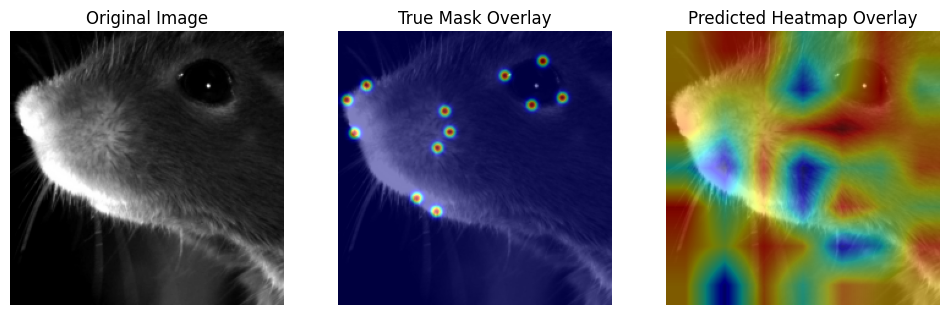

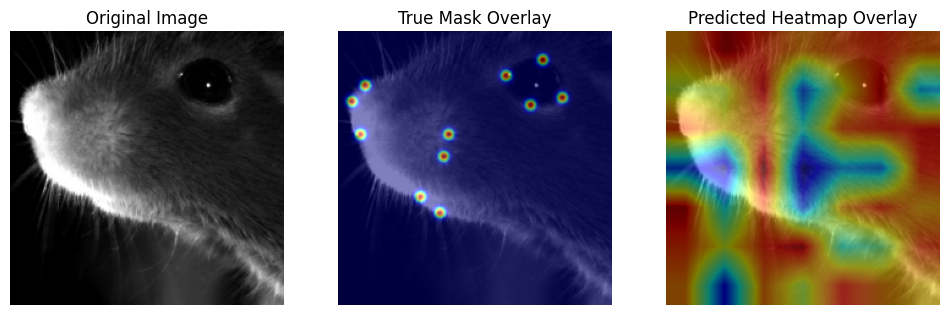

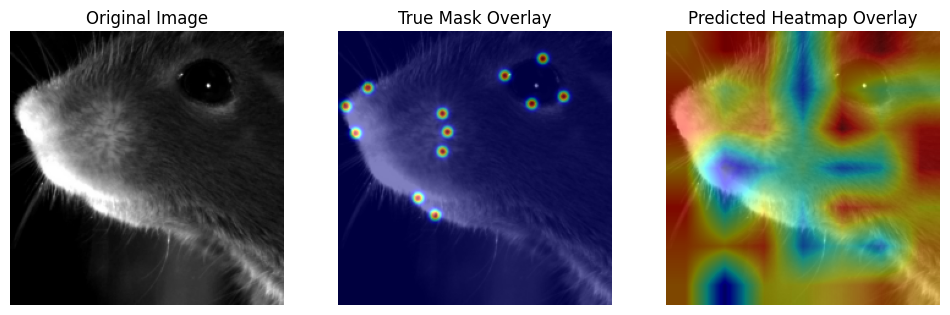

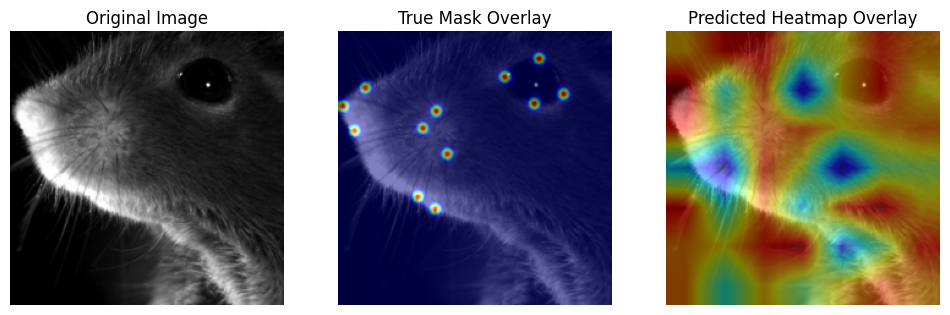

In [31]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Define the test dataset
test_dataset = FaceMapDataset(data_file="data/facemap_softlabels_test_RGB.pt", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load the trained model weights
#model = SimpleSwinHeatmap().to(device)
#model.load_state_dict(torch.load('simple_swin_heatmap.pth'))
# Function to overlay predictions on images
def plot_overlay(image, mask, prediction, alpha=0.5):
    """
    Overlays the heatmap prediction on the original image.
    """
    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) format for plt
    mask_np = mask.cpu().squeeze().numpy()
    prediction_np = prediction.cpu().squeeze().numpy()  # Convert to (H, W) for heatmap

    # Normalize prediction heatmap to [0, 1] for better visualization
    mask_np = (mask_np - mask_np.min()) / (mask_np.max() - mask_np.min())
    prediction_np = (prediction_np - prediction_np.min()) / (prediction_np.max() - prediction_np.min())

    # Plotting the image and overlay
    plt.figure(figsize=(12, 4))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the true mask overlay
    plt.subplot(1, 3, 2)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(mask_np, cmap='jet', alpha=alpha)  # Overlay true mask with transparency
    plt.title("True Mask Overlay")
    plt.axis('off')

    # Display the predicted heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(prediction_np, cmap='jet', alpha=alpha)  # Overlay prediction with transparency
    plt.title("Predicted Heatmap Overlay")
    plt.axis('off')

    plt.show()

model.eval()
# Loop through the test dataset
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        predictions = model(images)  # Get the heatmap predictions
    
    # Plot each image with its overlay
    for i in range(images.size(0)):
        plot_overlay(images[i], masks[i], predictions[i])
    break